# Basics with string sequence

## Shape of One-Hot encoded data

In [1]:
# EpyNN/nnlive/dummy_string/train.ipynb
# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.flatten.models import Flatten
from nnlibs.rnn.models import RNN
from nnlibs.gru.models import GRU
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=512)

embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

## Flatten and output using Dense layer

In [2]:
name = 'Flatten_Dense-2-softmax'

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, flatten, dense]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


In [3]:
model.train(epochs=100, init_logs=False)

+-------+----------+-------+----------+-------+-------+------------------------------------+
| epoch |  lrate   |       | accuracy |       |  MSE  |             Experiment             |
|       |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                    |
+-------+----------+-------+----------+-------+-------+------------------------------------+
|   0   | 1.00e-01 | 0.677 |  0.708   | 0.271 | 0.246 | 1628548907_Flatten_Dense-2-softmax |
|  10   | 1.00e-01 | 0.757 |  0.713   | 0.213 | 0.227 | 1628548907_Flatten_Dense-2-softmax |
|  20   | 1.00e-01 | 0.777 |  0.719   | 0.193 | 0.221 | 1628548907_Flatten_Dense-2-softmax |
|  30   | 1.00e-01 | 0.812 |  0.731   | 0.186 | 0.213 | 1628548907_Flatten_Dense-2-softmax |
|  40   | 1.00e-01 | 0.815 |  0.731   | 0.181 | 0.210 | 1628548907_Flatten_Dense-2-softmax |
|  50   | 1.00e-01 | 0.818 |  0.731   | 0.179 | 0.210 | 1628548907_Flatten_Dense-2-softmax |
|  60   | 1.00e-01 | 0.815 |  0.737   | 0.178 | 0.212 | 1628548907_Fla

## Recurrent Architectures

### Recurrent Neural Network (RNN)

In [4]:
name = 'rnn-12_Dense-2-softmax'

rnn = RNN(12)

dense = Dense(2, softmax)

layers = [embedding, rnn, dense]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: RNN
compute_shapes: RNN
initialize_parameters: RNN
forward: RNN
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: RNN
backward: RNN
compute_gradients: RNN
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


In [5]:
model.train(epochs=100, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |            Experiment             |
|       |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                   |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 0.704 |  0.731   | 0.229 | 0.207 | 1628548908_rnn-12_Dense-2-softmax |
|  10   | 1.00e-01 | 1.00e-01 | 0.733 |  0.760   | 0.197 | 0.198 | 1628548908_rnn-12_Dense-2-softmax |
|  20   | 1.00e-01 | 1.00e-01 | 0.727 |  0.760   | 0.192 | 0.195 | 1628548908_rnn-12_Dense-2-softmax |
|  30   | 1.00e-01 | 1.00e-01 | 0.724 |  0.754   | 0.191 | 0.193 | 1628548908_rnn-12_Dense-2-softmax |
|  40   | 1.00e-01 | 1.00e-01 | 0.727 |  0.754   | 0.190 | 0.194 | 1628548908_rnn-12_Dense-2-softmax |
|  50   | 1.00e-01 | 1.00e-01 | 0.748 |  0.754   | 0.184 | 0.189 | 162854

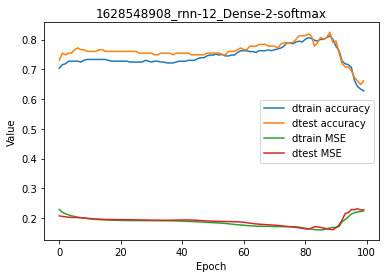

In [6]:
model.plot(path=False)

### Deep Recurrent Neural Network (DRNN)

In [7]:
name = 'rnn-12_rnn-12_Dense-2-softmax'

rnn = RNN(12, sequences=True)

rnn_bis = RNN(12)

dense = Dense(2, softmax)

layers = [embedding, rnn, rnn_bis, dense]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1, se_hPars=se_hPars)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: RNN
compute_shapes: RNN
initialize_parameters: RNN
forward: RNN
Layer: RNN
compute_shapes: RNN
initialize_parameters: RNN
forward: RNN
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: RNN
backward: RNN
compute_gradients: RNN
Layer: RNN
backward: RNN
compute_gradients: RNN
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


In [8]:
model.train(epochs=100, init_logs=False)

+-------+----------+----------+----------+-------+----------+-------+-------+------------------------------------------+
| epoch |  lrate   |  lrate   |  lrate   |       | accuracy |       |  MSE  |                Experiment                |
|       |   RNN    |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                          |
+-------+----------+----------+----------+-------+----------+-------+-------+------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.721 |  0.760   | 0.223 | 0.203 | 1628548910_rnn-12_rnn-12_Dense-2-softmax |
|  10   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.733 |  0.760   | 0.187 | 0.194 | 1628548910_rnn-12_rnn-12_Dense-2-softmax |
|  20   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.733 |  0.737   | 0.181 | 0.197 | 1628548910_rnn-12_rnn-12_Dense-2-softmax |
|  30   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.742 |  0.737   | 0.178 | 0.198 | 1628548910_rnn-12_rnn-12_Dense-2-softmax |
|  40   | 1.00e-01 | 1.00e-01 | 

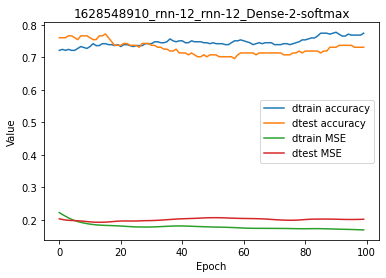

In [9]:
model.plot(path=False)

### Composite Architectures

In [10]:
name = 'rnn-12_gru-12_Flatten_Dense-4-relu_Dense-2-softmax'

rnn = RNN(12, sequences=True)

gru = GRU(12, sequences=True)

flatten = Flatten()

hidden_dense = Dense(4, relu)

dense = Dense(2, softmax)

layers = [embedding, rnn, gru, flatten, hidden_dense, dense]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1, se_hPars=se_hPars)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: RNN
compute_shapes: RNN
initialize_parameters: RNN
forward: RNN
Layer: GRU
compute_shapes: GRU
initialize_parameters: GRU
forward: GRU
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: GRU
backward: GRU
compute_gradients: GRU
Layer: RNN
backward: RNN
compute_gradients: RNN
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


In [11]:
model.train(epochs=100, init_logs=False)

+-------+----------+----------+----------+----------+-------+----------+-------+-------+---------------------------------------------------------------+
| epoch |  lrate   |  lrate   |  lrate   |  lrate   |       | accuracy |       |  MSE  |                          Experiment                           |
|       |   RNN    |   GRU    |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                               |
+-------+----------+----------+----------+----------+-------+----------+-------+-------+---------------------------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.730 |  0.766   | 0.197 | 0.179 | 1628548913_rnn-12_gru-12_Flatten_Dense-4-relu_Dense-2-softmax |
|  10   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.768 |  0.725   | 0.173 | 0.194 | 1628548913_rnn-12_gru-12_Flatten_Dense-4-relu_Dense-2-softmax |
|  20   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.795 |  0.719   | 0.146 | 0

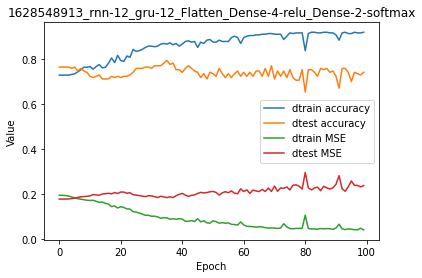

In [12]:
model.plot(path=False)